In [1]:
import pandas as pd
import numpy as np
import keras
from datetime import datetime
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras import losses
from keras.constraints import maxnorm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import seaborn as sns
sns.set()
from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint
import shap
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report
import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from commons import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Audio
#sound_file = 'beep.wav'
from keras.callbacks import *

Using TensorFlow backend.
/Users/liuxuyang/opt/anaconda3/envs/mytensorflow/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Litecoin

In [3]:
regs = pd.read_csv("ltc_reg.csv")
btc = pd.read_csv("litecoin_Data.csv")
for i in range(len(btc['Date'])):
    btc['Date'][i]  =  datetime.strptime(btc['Date'][i], '%Y/%m/%d')

btc = btc.set_index("Date")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
btcData = btc[regs.columns]

In [5]:
btcData['returns'] = btcData['priceUSD'].pct_change()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
Data = btcData.drop(columns=['priceUSD'])
Data = Data[1:]

In [11]:
Data 

,activeaddresses30std,activeaddresses30var,activeaddresses7trx,difficulty,difficulty30mom,difficulty30trx,difficulty90mom,difficulty90roc,difficulty90rsi,difficulty90trx,...,sentinusd30emaUSD,sentinusd30smaUSD,sentinusd30wmaUSD,sentinusd90emaUSD,sentinusd90varUSD,sentinusd90wmaUSD,sentinusdUSD,top100cap,transactionvalueUSD,returns
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,7666,14691594,0.296,51718,2875.000,0.146,3694.0,7.693,55.143,0.073,...,13119990,14447549,13084361,15062343,9.207781e+13,15267519,6145265,49.907,1299.0,-0.004836
2016-01-03,7553,14263642,0.531,50653,1810.000,0.152,2764.0,5.771,53.920,0.074,...,12661408,14247155,12540130,14863434,9.237091e+13,15058214,6011974,49.914,1650.0,-0.008005
2016-01-04,6990,12215979,0.492,50158,1315.000,0.156,2268.0,4.737,53.364,0.074,...,12160118,13934412,11936534,14644269,9.336173e+13,14824650,4891418,49.963,1112.0,0.004323
2016-01-05,7207,12983796,-0.176,50158,436.688,0.159,1731.0,3.574,53.364,0.075,...,11733962,13588124,11395907,14444498,9.368327e+13,14607077,5554693,49.976,1505.0,-0.004878
2016-01-06,7368,13572232,-0.950,51299,1184.000,0.161,1473.0,2.956,54.471,0.075,...,11652530,13295257,11194853,14357186,9.312956e+13,14497960,10471777,49.916,3469.0,-0.004902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-24,55298,764459612,-0.329,19352505,2570167.000,0.274,3935133.0,25.524,61.809,0.095,...,1038289555,1236990379,1125469305,906646434,7.982758e+17,1088633253,361588723,44.670,30828.0,-0.001286
2022-11-25,55854,779921846,-0.097,19996996,3214659.000,0.279,4316584.0,27.529,63.623,0.097,...,990339490,1228280282,1064699832,893205052,7.936632e+17,1076450910,295063546,44.667,37548.0,-0.023929
2022-11-26,55376,766634614,-0.101,19996996,3214659.000,0.284,4316584.0,27.529,63.623,0.099,...,939695376,1214390963,998704699,878087484,7.902356e+17,1062224912,205355717,44.746,35847.0,0.012488


In [12]:
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = btcData['priceUSD'].shift(-30)[1:] # 反之亦然

In [13]:
X.head(3)

,activeaddresses30std,activeaddresses30var,activeaddresses7trx,difficulty,difficulty30mom,difficulty30trx,difficulty90mom,difficulty90roc,difficulty90rsi,difficulty90trx,...,sentinusd30emaUSD,sentinusd30smaUSD,sentinusd30wmaUSD,sentinusd90emaUSD,sentinusd90varUSD,sentinusd90wmaUSD,sentinusdUSD,top100cap,transactionvalueUSD,returns
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,7666,14691594,0.296,51718,2875.0,0.146,3694.0,7.693,55.143,0.073,...,13119990,14447549,13084361,15062343,9.207781e+13,15267519,6145265,49.907,1299.0,-0.004836
2016-01-03,7553,14263642,0.531,50653,1810.0,0.152,2764.0,5.771,53.920,0.074,...,12661408,14247155,12540130,14863434,9.237091e+13,15058214,6011974,49.914,1650.0,-0.008005
2016-01-04,6990,12215979,0.492,50158,1315.0,0.156,2268.0,4.737,53.364,0.074,...,12160118,13934412,11936534,14644269,9.336173e+13,14824650,4891418,49.963,1112.0,0.004323


In [14]:
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

In [15]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


Pipeline(steps=[('mixmax', MinMaxScaler()), ['robust', RobustScaler()]],
         verbose=True)

In [16]:
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)

In [17]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [18]:
from keras import regularizers
# define neural network model
shape=X.shape[1]
def sequential_model(initializer='normal', activation='relu', neurons=300, NUM_FEATURES=shape):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_shape=(NUM_FEATURES,), kernel_initializer=initializer, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(1, activation=activation))
    # Compile model
    adam=keras.optimizers.adam(lr=lr_schedule(0), amsgrad=True)
    #sgd=keras.optimizers.SGD(learning_rate=0.08, momentum=0.9, nesterov=False)
    model.compile(loss='logcosh', optimizer=adam, metrics=['mae'])
    return model

In [19]:
#mcp_save = ModelCheckpoint('trained_models/ANN_reg_seven_new.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
#earlyStopping = EarlyStopping(monitor='val_loss', patience=100,verbose=1, mode='auto')

In [20]:
regressor=KerasRegressor(build_fn=sequential_model,epochs=1000,verbose=1, shuffle=True,use_multiprocessing=True)

In [21]:
regressor.fit(X_train,Y_train,validation_data=(X_val, Y_val))
#Audio(sound_file,autoplay=True)

2022-11-30 19:16:54.410464: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 19:16:54.413014: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Learning rate:  0.001
Train on 1460 samples, validate on 517 samples
Epoch 1/1000
1460/1460 [==============================] - 1s 855us/step - loss: 33.7555 - mae: 34.4062 - val_loss: 51.7082 - val_mae: 52.3987
Epoch 2/1000
1460/1460 [==============================] - 0s 287us/step - loss: 16.5764 - mae: 17.1856 - val_loss: 37.0793 - val_mae: 37.7594
Epoch 3/1000
1460/1460 [==============================] - 0s 283us/step - loss: 12.7259 - mae: 13.3295 - val_loss: 39.1565 - val_mae: 39.8393
Epoch 4/1000
1460/1460 [==============================] - 0s 276us/step - loss: 11.3543 - mae: 11.9527 - val_loss: 39.3681 - val_mae: 40.0523
Epoch 5/1000
1460/1460 [==============================] - 0s 273us/step - loss: 10.5871 - mae: 11.1776 - val_loss: 42.6258 - val_mae: 43.3083
Epoch 6/1000
1460/1460 [==============================] - 0s 274us/step - loss: 9.2377 - mae: 9.8268 - val_loss: 41.7024 - val_mae: 42.3844
Epoch 7/1000
1460/1460 [==============================] - 0s 275us/step - loss: 9

1460/1460 [==============================] - 0s 332us/step - loss: 2.5391 - mae: 3.0166 - val_loss: 47.4454 - val_mae: 48.1206
Epoch 59/1000
1460/1460 [==============================] - 0s 332us/step - loss: 2.7200 - mae: 3.2016 - val_loss: 48.5609 - val_mae: 49.2396
Epoch 60/1000
1460/1460 [==============================] - 0s 304us/step - loss: 2.7893 - mae: 3.2813 - val_loss: 46.9856 - val_mae: 47.6620
Epoch 61/1000
1460/1460 [==============================] - 0s 336us/step - loss: 2.5601 - mae: 3.0532 - val_loss: 45.7705 - val_mae: 46.4466
Epoch 62/1000
1460/1460 [==============================] - 1s 343us/step - loss: 2.9417 - mae: 3.4448 - val_loss: 47.4528 - val_mae: 48.1280
Epoch 63/1000
1460/1460 [==============================] - 0s 317us/step - loss: 2.6530 - mae: 3.1433 - val_loss: 45.2880 - val_mae: 45.9669
Epoch 64/1000
1460/1460 [==============================] - 0s 299us/step - loss: 2.9355 - mae: 3.4257 - val_loss: 45.0836 - val_mae: 45.7627
Epoch 65/1000
1460/1460 [==

1460/1460 [==============================] - 0s 290us/step - loss: 1.8842 - mae: 2.3366 - val_loss: 46.7307 - val_mae: 47.4104
Epoch 117/1000
1460/1460 [==============================] - 0s 258us/step - loss: 1.8616 - mae: 2.3116 - val_loss: 46.8611 - val_mae: 47.5388
Epoch 118/1000
1460/1460 [==============================] - 0s 309us/step - loss: 2.2623 - mae: 2.7382 - val_loss: 48.2820 - val_mae: 48.9581
Epoch 119/1000
1460/1460 [==============================] - 0s 293us/step - loss: 2.2146 - mae: 2.6758 - val_loss: 45.9570 - val_mae: 46.6357
Epoch 120/1000
1460/1460 [==============================] - 0s 276us/step - loss: 2.1015 - mae: 2.5685 - val_loss: 47.0101 - val_mae: 47.6856
Epoch 121/1000
1460/1460 [==============================] - 0s 291us/step - loss: 1.7685 - mae: 2.2178 - val_loss: 48.6779 - val_mae: 49.3554
Epoch 122/1000
1460/1460 [==============================] - 0s 275us/step - loss: 2.0090 - mae: 2.4654 - val_loss: 47.2760 - val_mae: 47.9504
Epoch 123/1000
1460/1

Epoch 174/1000
1460/1460 [==============================] - 0s 272us/step - loss: 1.6944 - mae: 2.1229 - val_loss: 47.8673 - val_mae: 48.5528
Epoch 175/1000
1460/1460 [==============================] - 0s 282us/step - loss: 1.8195 - mae: 2.2614 - val_loss: 48.2319 - val_mae: 48.9110
Epoch 176/1000
1460/1460 [==============================] - 0s 286us/step - loss: 2.1786 - mae: 2.6546 - val_loss: 48.3446 - val_mae: 49.0182
Epoch 177/1000
1460/1460 [==============================] - 0s 288us/step - loss: 1.7793 - mae: 2.2282 - val_loss: 47.7623 - val_mae: 48.4405
Epoch 178/1000
1460/1460 [==============================] - 0s 286us/step - loss: 1.7034 - mae: 2.1419 - val_loss: 46.8933 - val_mae: 47.5691
Epoch 179/1000
1460/1460 [==============================] - 0s 287us/step - loss: 1.8815 - mae: 2.3315 - val_loss: 48.1683 - val_mae: 48.8457
Epoch 180/1000
1460/1460 [==============================] - 0s 273us/step - loss: 1.9096 - mae: 2.3522 - val_loss: 49.5302 - val_mae: 50.2046
Epoch 

Epoch 232/1000
1460/1460 [==============================] - 0s 283us/step - loss: 1.4223 - mae: 1.8456 - val_loss: 49.3022 - val_mae: 49.9782
Epoch 233/1000
1460/1460 [==============================] - 0s 283us/step - loss: 1.3193 - mae: 1.7285 - val_loss: 48.3395 - val_mae: 49.0183
Epoch 234/1000
1460/1460 [==============================] - 0s 283us/step - loss: 1.5529 - mae: 1.9743 - val_loss: 48.2874 - val_mae: 48.9708
Epoch 235/1000
1460/1460 [==============================] - 0s 291us/step - loss: 1.3304 - mae: 1.7400 - val_loss: 47.2532 - val_mae: 47.9320
Epoch 236/1000
1460/1460 [==============================] - 0s 280us/step - loss: 1.5423 - mae: 1.9722 - val_loss: 48.9583 - val_mae: 49.6316
Epoch 237/1000
1460/1460 [==============================] - 0s 281us/step - loss: 1.3418 - mae: 1.7518 - val_loss: 48.4850 - val_mae: 49.1657
Epoch 238/1000
1460/1460 [==============================] - 0s 284us/step - loss: 1.2455 - mae: 1.6413 - val_loss: 49.8367 - val_mae: 50.5050
Epoch 

Epoch 290/1000
1460/1460 [==============================] - 0s 282us/step - loss: 1.0642 - mae: 1.4697 - val_loss: 49.8241 - val_mae: 50.5053
Epoch 291/1000
1460/1460 [==============================] - 0s 283us/step - loss: 1.4460 - mae: 1.8771 - val_loss: 49.8596 - val_mae: 50.5374
Epoch 292/1000
1460/1460 [==============================] - 0s 278us/step - loss: 1.3745 - mae: 1.7899 - val_loss: 48.8174 - val_mae: 49.4986
Epoch 293/1000
1460/1460 [==============================] - 0s 282us/step - loss: 1.2715 - mae: 1.6737 - val_loss: 50.3738 - val_mae: 51.0540
Epoch 294/1000
1460/1460 [==============================] - 0s 279us/step - loss: 1.0247 - mae: 1.4071 - val_loss: 49.6948 - val_mae: 50.3768
Epoch 295/1000
1460/1460 [==============================] - 0s 279us/step - loss: 1.2109 - mae: 1.6187 - val_loss: 49.9197 - val_mae: 50.6030
Epoch 296/1000
1460/1460 [==============================] - 0s 282us/step - loss: 1.4759 - mae: 1.8916 - val_loss: 49.9146 - val_mae: 50.5902
Epoch 

Epoch 348/1000
1460/1460 [==============================] - 0s 276us/step - loss: 1.1393 - mae: 1.5328 - val_loss: 49.3420 - val_mae: 50.0261
Epoch 349/1000
1460/1460 [==============================] - 0s 273us/step - loss: 1.1000 - mae: 1.4975 - val_loss: 49.7344 - val_mae: 50.4180
Epoch 350/1000
1460/1460 [==============================] - 0s 270us/step - loss: 1.1383 - mae: 1.5397 - val_loss: 48.5655 - val_mae: 49.2487
Epoch 351/1000
1460/1460 [==============================] - 0s 304us/step - loss: 1.0997 - mae: 1.5049 - val_loss: 49.0107 - val_mae: 49.6929
Epoch 352/1000
1460/1460 [==============================] - 0s 276us/step - loss: 1.2133 - mae: 1.6108 - val_loss: 49.1815 - val_mae: 49.8629
Epoch 353/1000
1460/1460 [==============================] - 0s 271us/step - loss: 1.1635 - mae: 1.5543 - val_loss: 49.1189 - val_mae: 49.8026
Epoch 354/1000
1460/1460 [==============================] - 0s 270us/step - loss: 0.9206 - mae: 1.2943 - val_loss: 49.6591 - val_mae: 50.3429
Epoch 

Epoch 406/1000
1460/1460 [==============================] - 0s 270us/step - loss: 0.8059 - mae: 1.1656 - val_loss: 49.8372 - val_mae: 50.5200
Epoch 407/1000
1460/1460 [==============================] - 0s 282us/step - loss: 0.9769 - mae: 1.3501 - val_loss: 49.8835 - val_mae: 50.5631
Epoch 408/1000
1460/1460 [==============================] - 0s 267us/step - loss: 1.0236 - mae: 1.4002 - val_loss: 49.8788 - val_mae: 50.5601
Epoch 409/1000
1460/1460 [==============================] - 0s 272us/step - loss: 1.1333 - mae: 1.5331 - val_loss: 49.0883 - val_mae: 49.7672
Epoch 410/1000
1460/1460 [==============================] - 0s 269us/step - loss: 1.0949 - mae: 1.4953 - val_loss: 50.4255 - val_mae: 51.1059
Epoch 411/1000
1460/1460 [==============================] - 0s 264us/step - loss: 0.9818 - mae: 1.3502 - val_loss: 49.2133 - val_mae: 49.8936
Epoch 412/1000
1460/1460 [==============================] - 0s 264us/step - loss: 0.9669 - mae: 1.3475 - val_loss: 49.7234 - val_mae: 50.4072
Epoch 

Epoch 464/1000
1460/1460 [==============================] - 0s 293us/step - loss: 0.9271 - mae: 1.3160 - val_loss: 49.8178 - val_mae: 50.4986
Epoch 465/1000
1460/1460 [==============================] - 0s 298us/step - loss: 0.8829 - mae: 1.2562 - val_loss: 49.8719 - val_mae: 50.5546
Epoch 466/1000
1460/1460 [==============================] - 0s 288us/step - loss: 0.9272 - mae: 1.3000 - val_loss: 49.7694 - val_mae: 50.4477
Epoch 467/1000
1460/1460 [==============================] - 0s 292us/step - loss: 0.8130 - mae: 1.1825 - val_loss: 50.0868 - val_mae: 50.7671
Epoch 468/1000
1460/1460 [==============================] - 0s 305us/step - loss: 0.9420 - mae: 1.3079 - val_loss: 50.1341 - val_mae: 50.8123
Epoch 469/1000
1460/1460 [==============================] - 0s 318us/step - loss: 0.8750 - mae: 1.2377 - val_loss: 49.6919 - val_mae: 50.3725
Epoch 470/1000
1460/1460 [==============================] - 0s 301us/step - loss: 0.7690 - mae: 1.1263 - val_loss: 49.5046 - val_mae: 50.1854
Epoch 

Epoch 522/1000
1460/1460 [==============================] - 0s 277us/step - loss: 0.7990 - mae: 1.1489 - val_loss: 49.7531 - val_mae: 50.4358
Epoch 523/1000
1460/1460 [==============================] - 0s 275us/step - loss: 0.8372 - mae: 1.2092 - val_loss: 49.8270 - val_mae: 50.5088
Epoch 524/1000
1460/1460 [==============================] - 0s 273us/step - loss: 0.9195 - mae: 1.2979 - val_loss: 49.3063 - val_mae: 49.9867
Epoch 525/1000
1460/1460 [==============================] - 0s 270us/step - loss: 0.6870 - mae: 1.0267 - val_loss: 50.3275 - val_mae: 51.0086
Epoch 526/1000
1460/1460 [==============================] - 0s 272us/step - loss: 0.7576 - mae: 1.1035 - val_loss: 49.5788 - val_mae: 50.2603
Epoch 527/1000
1460/1460 [==============================] - 0s 272us/step - loss: 0.9003 - mae: 1.2733 - val_loss: 49.6010 - val_mae: 50.2823
Epoch 528/1000
1460/1460 [==============================] - 0s 274us/step - loss: 0.8040 - mae: 1.1622 - val_loss: 49.0752 - val_mae: 49.7530
Epoch 

Epoch 580/1000
1460/1460 [==============================] - 0s 278us/step - loss: 0.6981 - mae: 1.0490 - val_loss: 48.8621 - val_mae: 49.5441
Epoch 581/1000
1460/1460 [==============================] - 0s 271us/step - loss: 0.7222 - mae: 1.0656 - val_loss: 49.5992 - val_mae: 50.2798
Epoch 582/1000
1460/1460 [==============================] - 0s 271us/step - loss: 0.8490 - mae: 1.2152 - val_loss: 50.3497 - val_mae: 51.0295
Epoch 583/1000
1460/1460 [==============================] - 0s 271us/step - loss: 0.9231 - mae: 1.2849 - val_loss: 49.5860 - val_mae: 50.2660
Epoch 584/1000
1460/1460 [==============================] - 0s 268us/step - loss: 0.6941 - mae: 1.0416 - val_loss: 49.9306 - val_mae: 50.6093
Epoch 585/1000
1460/1460 [==============================] - 0s 275us/step - loss: 0.7626 - mae: 1.0991 - val_loss: 50.3335 - val_mae: 51.0146
Epoch 586/1000
1460/1460 [==============================] - 0s 270us/step - loss: 0.7366 - mae: 1.0895 - val_loss: 49.2925 - val_mae: 49.9731
Epoch 

Epoch 638/1000
1460/1460 [==============================] - 0s 267us/step - loss: 0.9048 - mae: 1.2561 - val_loss: 50.0407 - val_mae: 50.7198
Epoch 639/1000
1460/1460 [==============================] - 0s 273us/step - loss: 0.8143 - mae: 1.1566 - val_loss: 49.9536 - val_mae: 50.6332
Epoch 640/1000
1460/1460 [==============================] - 0s 271us/step - loss: 0.8037 - mae: 1.1602 - val_loss: 49.1089 - val_mae: 49.7890
Epoch 641/1000
1460/1460 [==============================] - 0s 266us/step - loss: 0.7444 - mae: 1.0923 - val_loss: 49.9373 - val_mae: 50.6180
Epoch 642/1000
1460/1460 [==============================] - 0s 268us/step - loss: 0.6338 - mae: 0.9640 - val_loss: 49.7782 - val_mae: 50.4574
Epoch 643/1000
1460/1460 [==============================] - 0s 265us/step - loss: 0.6041 - mae: 0.9242 - val_loss: 50.5958 - val_mae: 51.2770
Epoch 644/1000
1460/1460 [==============================] - 0s 276us/step - loss: 0.6648 - mae: 1.0174 - val_loss: 50.2099 - val_mae: 50.8897
Epoch 

Epoch 696/1000
1460/1460 [==============================] - 0s 294us/step - loss: 0.6725 - mae: 1.0182 - val_loss: 49.3894 - val_mae: 50.0718
Epoch 697/1000
1460/1460 [==============================] - 0s 296us/step - loss: 0.9065 - mae: 1.2732 - val_loss: 50.6095 - val_mae: 51.2919
Epoch 698/1000
1460/1460 [==============================] - 0s 287us/step - loss: 0.9887 - mae: 1.3780 - val_loss: 50.4671 - val_mae: 51.1479
Epoch 699/1000
1460/1460 [==============================] - 0s 303us/step - loss: 0.7299 - mae: 1.0901 - val_loss: 50.3617 - val_mae: 51.0421
Epoch 700/1000
1460/1460 [==============================] - 0s 289us/step - loss: 0.7649 - mae: 1.1125 - val_loss: 49.8086 - val_mae: 50.4872
Epoch 701/1000
1460/1460 [==============================] - 0s 287us/step - loss: 0.7279 - mae: 1.0729 - val_loss: 50.3850 - val_mae: 51.0647
Epoch 702/1000
1460/1460 [==============================] - 0s 278us/step - loss: 0.5744 - mae: 0.9081 - val_loss: 49.7014 - val_mae: 50.3816
Epoch 

Epoch 754/1000
1460/1460 [==============================] - 0s 286us/step - loss: 0.5194 - mae: 0.8224 - val_loss: 50.5186 - val_mae: 51.1998
Epoch 755/1000
1460/1460 [==============================] - 0s 288us/step - loss: 0.6184 - mae: 0.9529 - val_loss: 50.0849 - val_mae: 50.7638
Epoch 756/1000
1460/1460 [==============================] - 0s 284us/step - loss: 0.7042 - mae: 1.0388 - val_loss: 50.6653 - val_mae: 51.3422
Epoch 757/1000
1460/1460 [==============================] - 0s 286us/step - loss: 0.7738 - mae: 1.1295 - val_loss: 49.8741 - val_mae: 50.5529
Epoch 758/1000
1460/1460 [==============================] - 0s 288us/step - loss: 0.7438 - mae: 1.0815 - val_loss: 50.1485 - val_mae: 50.8256
Epoch 759/1000
1460/1460 [==============================] - 0s 292us/step - loss: 0.9777 - mae: 1.3505 - val_loss: 49.4673 - val_mae: 50.1477
Epoch 760/1000
1460/1460 [==============================] - 0s 291us/step - loss: 0.6573 - mae: 1.0016 - val_loss: 49.3906 - val_mae: 50.0712
Epoch 

Epoch 812/1000
1460/1460 [==============================] - 0s 286us/step - loss: 0.5181 - mae: 0.8236 - val_loss: 50.4570 - val_mae: 51.1377
Epoch 813/1000
1460/1460 [==============================] - 0s 283us/step - loss: 0.5596 - mae: 0.8792 - val_loss: 49.9026 - val_mae: 50.5820
Epoch 814/1000
1460/1460 [==============================] - 0s 282us/step - loss: 0.5743 - mae: 0.8972 - val_loss: 50.3867 - val_mae: 51.0647
Epoch 815/1000
1460/1460 [==============================] - 0s 278us/step - loss: 0.7657 - mae: 1.1205 - val_loss: 50.5862 - val_mae: 51.2646
Epoch 816/1000
1460/1460 [==============================] - 0s 285us/step - loss: 0.6181 - mae: 0.9439 - val_loss: 49.9638 - val_mae: 50.6430
Epoch 817/1000
1460/1460 [==============================] - 0s 281us/step - loss: 0.5597 - mae: 0.8682 - val_loss: 50.4460 - val_mae: 51.1229
Epoch 818/1000
1460/1460 [==============================] - 0s 281us/step - loss: 0.4831 - mae: 0.7870 - val_loss: 50.1867 - val_mae: 50.8642
Epoch 

Epoch 870/1000
1460/1460 [==============================] - 0s 292us/step - loss: 0.7158 - mae: 1.0669 - val_loss: 50.0608 - val_mae: 50.7392
Epoch 871/1000
1460/1460 [==============================] - 0s 292us/step - loss: 0.6169 - mae: 0.9507 - val_loss: 50.3801 - val_mae: 51.0564
Epoch 872/1000
1460/1460 [==============================] - 0s 294us/step - loss: 0.5038 - mae: 0.8100 - val_loss: 50.6264 - val_mae: 51.3029
Epoch 873/1000
1460/1460 [==============================] - 0s 291us/step - loss: 0.7392 - mae: 1.0904 - val_loss: 50.3164 - val_mae: 50.9970
Epoch 874/1000
1460/1460 [==============================] - 0s 285us/step - loss: 0.4778 - mae: 0.7773 - val_loss: 49.9978 - val_mae: 50.6791
Epoch 875/1000
1460/1460 [==============================] - 0s 301us/step - loss: 0.5618 - mae: 0.8785 - val_loss: 50.2560 - val_mae: 50.9349
Epoch 876/1000
1460/1460 [==============================] - 0s 295us/step - loss: 0.5902 - mae: 0.9126 - val_loss: 49.2958 - val_mae: 49.9754
Epoch 

Epoch 928/1000
1460/1460 [==============================] - 0s 271us/step - loss: 0.4697 - mae: 0.7700 - val_loss: 49.7925 - val_mae: 50.4730
Epoch 929/1000
1460/1460 [==============================] - 0s 272us/step - loss: 0.7348 - mae: 1.0950 - val_loss: 50.3553 - val_mae: 51.0303
Epoch 930/1000
1460/1460 [==============================] - 0s 273us/step - loss: 0.5897 - mae: 0.9140 - val_loss: 50.1066 - val_mae: 50.7852
Epoch 931/1000
1460/1460 [==============================] - 0s 272us/step - loss: 0.5248 - mae: 0.8393 - val_loss: 50.2314 - val_mae: 50.9127
Epoch 932/1000
1460/1460 [==============================] - 0s 273us/step - loss: 0.5039 - mae: 0.8171 - val_loss: 49.8786 - val_mae: 50.5554
Epoch 933/1000
1460/1460 [==============================] - 0s 275us/step - loss: 0.6073 - mae: 0.9334 - val_loss: 49.8545 - val_mae: 50.5331
Epoch 934/1000
1460/1460 [==============================] - 0s 270us/step - loss: 0.4861 - mae: 0.7835 - val_loss: 50.4586 - val_mae: 51.1316
Epoch 

Epoch 986/1000
1460/1460 [==============================] - 0s 283us/step - loss: 0.4936 - mae: 0.8067 - val_loss: 49.7873 - val_mae: 50.4687
Epoch 987/1000
1460/1460 [==============================] - 0s 292us/step - loss: 0.4845 - mae: 0.7920 - val_loss: 50.3419 - val_mae: 51.0172
Epoch 988/1000
1460/1460 [==============================] - 0s 291us/step - loss: 0.4643 - mae: 0.7866 - val_loss: 49.6488 - val_mae: 50.3290
Epoch 989/1000
1460/1460 [==============================] - 0s 280us/step - loss: 0.5470 - mae: 0.8697 - val_loss: 50.5821 - val_mae: 51.2608
Epoch 990/1000
1460/1460 [==============================] - 0s 293us/step - loss: 0.6415 - mae: 0.9827 - val_loss: 50.1919 - val_mae: 50.8715
Epoch 991/1000
1460/1460 [==============================] - 0s 281us/step - loss: 0.4120 - mae: 0.6930 - val_loss: 50.7375 - val_mae: 51.4138
Epoch 992/1000
1460/1460 [==============================] - 0s 287us/step - loss: 0.4637 - mae: 0.7641 - val_loss: 50.3506 - val_mae: 51.0236
Epoch 

In [22]:
# for check
y_train_pred=regressor.predict(X_train)
r2_score(Y_train, y_train_pred) #training score

1460/1460 [==============================] - 0s 147us/step


0.9989266512976384

In [23]:
y_pred=regressor.predict(X_test)
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['y_test','y_pred'])
pre_df.index = Y_test.index
pre_df

546/546 [==============================] - 0s 94us/step


,y_test,y_pred
Date,,
2021-06-01,137.796,121.369370
2021-06-02,133.855,107.409111
2021-06-03,138.441,100.333031
2021-06-04,143.405,99.039787
2021-06-05,139.483,93.733871
...,...,...
2022-11-24,NaN,112.721184
2022-11-25,NaN,108.901176
2022-11-26,NaN,114.515366


In [27]:
r2=r2_score(Y_test[0:-30],y_pred[0:-30]) #testing score/ r^2
r2

-1.1489813188312699

In [23]:
rmse=np.sqrt(mean_squared_error(Y_test[],y_pred)) #rmse
rmse#太特么大了，感觉数据集划分有问题

80.45185770601903

In [24]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [25]:
pre_df

,y_test,y_pred,pred_returns
Date,,,
2021-06-01,182.100,172.572250,NaN
2021-06-02,184.982,176.386429,0.022102
2021-06-03,190.269,181.590149,0.029502
2021-06-04,178.475,168.729507,-0.070822
2021-06-05,177.253,171.037537,0.013679
...,...,...,...
2022-11-24,77.689,69.559685,-0.094985
2022-11-25,75.830,71.954208,0.034424
2022-11-26,76.777,74.224960,0.031558


<AxesSubplot:>

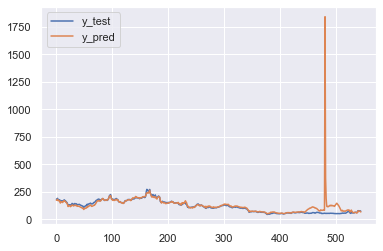

In [26]:
pd.DataFrame(zip(Y_test,y_pred),columns=['y_test','y_pred']).plot()

In [27]:
pre_df.to_csv("ltc_NN.csv")